### Fish tested twice in the morning and twice in the afternoon (once with E2, once with Met)

- Paired t-test

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import stats
import seaborn as sns
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

In [13]:
def divide_data_by_flow_direction(data):
    '''Dividing raw data from one fish into 2 dataframes with either left or right OMR flow'''
    data.columns = ['X_coord', 'Y_coord', 'heading_direction', \
                'cumulative_direction','beat_freq', 'beat_amp', \
                'tail_move?', 'timestamp', 'contrast_level', 'flow_direction']
    right = pd.DataFrame(data[data.flow_direction == 1])
    left = pd.DataFrame(data[data.flow_direction == 2])
    zero = pd.DataFrame(data[data.flow_direction == 0])

    return right, left, zero

def divide_data_by_contrast(data):
    '''Dividing raw data from one fish and one flow direction into contrast levels'''
    C_0 = pd.DataFrame(data[data.contrast_level == 0])
    C_01 = pd.DataFrame(data[data.contrast_level == 0.01])
    C_1 = pd.DataFrame(data[data.contrast_level == 0.1])
    C_2 = pd.DataFrame(data[data.contrast_level == 0.2])
    C_3 = pd.DataFrame(data[data.contrast_level == 0.3])
    C_5 = pd.DataFrame(data[data.contrast_level == 0.5])
    C_7 = pd.DataFrame(data[data.contrast_level == 0.7])
    C_10 = pd.DataFrame(data[data.contrast_level == 1])
    return C_0, C_01, C_1, C_2, C_3, C_5, C_7, C_10

def omr_preprocess(data):
    # remove timestamp and extras
    # keep x, y, heading, cumulative, timestamp
    new = data.drop(columns = ['beat_freq', 'beat_amp','tail_move?','contrast_level','flow_direction'])


    # resetting index
    new = pd.DataFrame(new)
    new = new.set_index('timestamp').reset_index()


    # remove time points where there was an angle change of more than pi from one frame to another
    for row in range(len(new)-1):
        heading = new.iloc[row,3]
        next_heading = new.iloc[row+1,3]
        if np.abs(next_heading-heading) >= 2.0:
            new.iloc[row+1,3] = new.iloc[row,3]


    # interpolating and normalising data to a fixed set of points
    interp = pd.DataFrame(columns=['timestamp','X_coord','Y_coord','heading_direction','cumulative_direction'])
    for column in new.columns:
        x = np.arange(0,len(new))
        y = new[column]
        f = interpolate.interp1d(x,y)

        x_new = np.arange(0,3000,1)
        y_new = f(x_new)
        interp[column] = y_new


    # setting first cumulative_angle to zero and ajdusting all others
    interp.iloc[:,4] -= interp.iloc[0,4]


    # calculating distance traveled between each timeframe
    # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
    interp['distance_pts'] = 0
    for row in range(1,len(interp),1):
        distance = np.sqrt((interp['X_coord'][row]-interp['X_coord'][row-1])**2\
                            +(interp['Y_coord'][row]-interp['Y_coord'][row-1])**2)
        interp.iloc[row,5] = distance


    # cleaning the timestamps
    interp.insert(0, 'new_timestamp', range(1, 1 + len(interp)))
    interp = interp.drop(columns=['timestamp']).rename(columns={'new_timestamp':'timestamp'})
    interp['timestamp'] = interp['timestamp']/1000

    return np.array(interp)

def combine_fish_data(*args):
    '''Combines preprocessed data from all fish into a 3D numpy array'''
    combined_fish = np.stack((args),axis=0)
    return combined_fish

In [14]:
fish1_E2_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish1_E2_AM.csv')
fish2_E2_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish2_E2_AM.csv')
fish3_E2_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish3_E2_AM.csv')

fish1_Met_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish1_Me_AM.csv')
fish2_Met_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish2_Me_AM.csv')
fish3_Met_AM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish3_Me_AM.csv')

fish1_E2_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish1_E2_PM.csv')
fish2_E2_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish2_E2_PM.csv')
fish3_E2_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish3_E2_PM.csv')
fish4_E2_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish4_E2_PM.csv')

fish1_Met_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish1_Me_PM.csv')
fish2_Met_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish2_Me_PM.csv')
fish3_Met_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish3_Me_PM.csv')
fish4_Met_PM = pd.read_csv('../raw_data/Paired_fish/xy_hc_fai_tstp_fish4_Me_PM.csv')

In [15]:
for e in range(1,4):
    exec(f'RE2_fish{e}_AM,LE2_fish{e}_AM,ZE2_fish{e} = divide_data_by_flow_direction(fish{e}_E2_AM)')
    exec(f'RMe_fish{e}_AM,LMe_fish{e}_AM,ZMe_fish{e} = divide_data_by_flow_direction(fish{e}_Met_AM)')
for e in range(1,5):
    exec(f'RE2_fish{e}_PM,LE2_fish{e}_PM,ZE2_fish{e} = divide_data_by_flow_direction(fish{e}_E2_PM)')
    exec(f'RMe_fish{e}_PM,LMe_fish{e}_PM,ZMe_fish{e} = divide_data_by_flow_direction(fish{e}_Met_PM)')

In [16]:
# LE2_fish1_AM --> LE2_fish1_AM_C01

for medium in ['E2','Me']:
    for di in ['R','L']:
        for i in range(1,4):
            exec(f'L{medium}_fish{i}_AM_C_0, L{medium}_fish{i}_AM_C_1, L{medium}_fish{i}_AM_C_10, \
                L{medium}_fish{i}_AM_C_20, L{medium}_fish{i}_AM_C_30, L{medium}_fish{i}_AM_C_50, \
                L{medium}_fish{i}_AM_C_70, L{medium}_fish{i}_AM_C_100 \
                = divide_data_by_contrast(L{medium}_fish{i}_AM)')
            exec(f'R{medium}_fish{i}_AM_C_0, R{medium}_fish{i}_AM_C_1, R{medium}_fish{i}_AM_C_10, \
                R{medium}_fish{i}_AM_C_20, R{medium}_fish{i}_AM_C_30, R{medium}_fish{i}_AM_C_50, \
                R{medium}_fish{i}_AM_C_70, R{medium}_fish{i}_AM_C_100 \
                = divide_data_by_contrast(L{medium}_fish{i}_AM)')
        for i in range(1,5):
            exec(f'L{medium}_fish{i}_PM_C_0, L{medium}_fish{i}_PM_C_1, L{medium}_fish{i}_PM_C_10, \
                L{medium}_fish{i}_PM_C_20, L{medium}_fish{i}_PM_C_30, L{medium}_fish{i}_PM_C_50, \
                L{medium}_fish{i}_PM_C_70, L{medium}_fish{i}_PM_C_100 \
                = divide_data_by_contrast(L{medium}_fish{i}_PM)')
            exec(f'R{medium}_fish{i}_PM_C_0, R{medium}_fish{i}_PM_C_1, R{medium}_fish{i}_PM_C_10, \
                R{medium}_fish{i}_PM_C_20, R{medium}_fish{i}_PM_C_30, R{medium}_fish{i}_PM_C_50, \
                R{medium}_fish{i}_PM_C_70, R{medium}_fish{i}_PM_C_100 \
                = divide_data_by_contrast(L{medium}_fish{i}_PM)')

In [17]:
for medium in ['E2','Me']:
    for flow in ['R','L']:
        for contrast in ['C_1','C_10','C_20','C_30','C_50','C_70','C_100']:
            for i in range(1,4):
                exec(f'{flow}{medium}_fish{i}_AM_{contrast} = omr_preprocess({flow}{medium}_fish{i}_AM_{contrast})')
            for i in range(1,5):
                exec(f'{flow}{medium}_fish{i}_PM_{contrast} = omr_preprocess({flow}{medium}_fish{i}_PM_{contrast})')

In [18]:
pd.DataFrame(LE2_fish1_PM_C_1)

,0,1,2,3,4,5
0,0.001,907.9461,387.6566,0.812098,0.000000,0.000000
1,0.002,908.0145,387.8589,0.779385,0.032713,0.213551
2,0.003,908.0113,387.8683,0.779871,0.032227,0.009930
3,0.004,907.9327,387.6621,0.812819,-0.000721,0.220673
4,0.005,908.0464,387.9161,0.780380,0.031718,0.278287
...,...,...,...,...,...,...
2995,2.996,940.8259,411.4378,0.613420,0.198678,0.124810
2996,2.997,940.6774,411.2645,0.610283,0.201814,0.228222
2997,2.998,940.7222,411.3322,0.611940,0.200158,0.081181
2998,2.999,940.5094,411.2979,0.617232,0.194866,0.215547


### Missing data:
- fish2_E2_AM
- fish3_E2_AM
- fish2_Met_PM

LE2_fish2_AM_C_1
RE2_fish2_AM_C_1


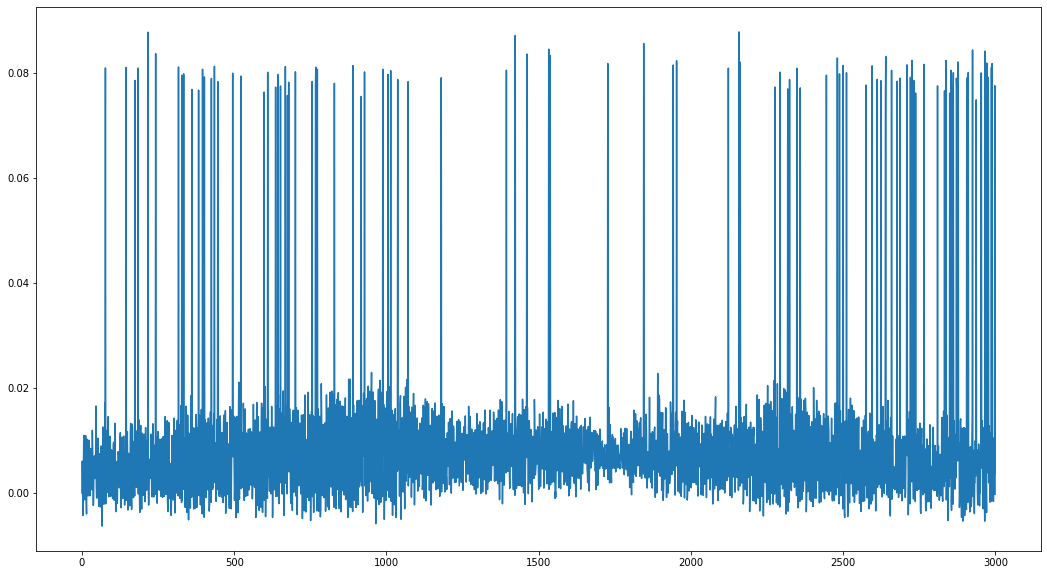

In [61]:
plt.subplots(1,1,figsize=(18,10))
plt.plot(RE2_fish2_AM_C_100[:,4])

In [ ]:
combined_L_E2_C_{c}_PM
combined_R_E2_C_{c}_PM
combined_L_E2_C_{c}_AM
combined_R_E2_C_{c}_AM
combined_L_Me_C_{c}_PM
combined_R_Me_C_{c}_PM
combined_L_Me_C_{c}_AM
combined_R_Me_C_{c}_AM

In [19]:
for medium in ['E2','Me']:
    for flow in ['R','L']:
        for contrast in ['C_1','C_10','C_20','C_30','C_50','C_70','C_100']:
            exec(f'combined_{flow}_{medium}_{contrast}_AM =\
                combine_fish_data({flow}{medium}_fish1_AM_{contrast},{flow}{medium}_fish2_AM_{contrast},\
                {flow}{medium}_fish3_AM_{contrast})')
            exec(f'combined_{flow}_{medium}_{contrast}_PM =\
                combine_fish_data({flow}{medium}_fish1_PM_{contrast},{flow}{medium}_fish2_PM_{contrast},\
                {flow}{medium}_fish3_PM_{contrast},{flow}{medium}_fish4_PM_{contrast})')

In [20]:
for c in ['1','10','20','30','50','70','100']:
    exec(f'avg_PM_LeC{c}_trajectory = np.mean(combined_L_E2_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_ReC{c}_trajectory = np.mean(combined_R_E2_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_LeC{c}_SEM = stats.sem(combined_L_E2_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_ReC{c}_SEM = stats.sem(combined_R_E2_C_{c}_PM[:,:,4],axis=0)')
    
    exec(f'avg_AM_LeC{c}_trajectory = np.mean(combined_L_E2_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_ReC{c}_trajectory = np.mean(combined_R_E2_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_LeC{c}_SEM = stats.sem(combined_L_E2_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_ReC{c}_SEM = stats.sem(combined_R_E2_C_{c}_AM[:,:,4],axis=0)')
    
    
    exec(f'avg_PM_LmeC{c}_trajectory = np.mean(combined_L_Me_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_RmeC{c}_trajectory = np.mean(combined_R_Me_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_LmeC{c}_SEM = stats.sem(combined_L_Me_C_{c}_PM[:,:,4],axis=0)')
    exec(f'avg_PM_RmeC{c}_SEM = stats.sem(combined_R_Me_C_{c}_PM[:,:,4],axis=0)')
    
    exec(f'avg_AM_LmeC{c}_trajectory = np.mean(combined_L_Me_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_RmeC{c}_trajectory = np.mean(combined_R_Me_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_LmeC{c}_SEM = stats.sem(combined_L_Me_C_{c}_AM[:,:,4],axis=0)')
    exec(f'avg_AM_RmeC{c}_SEM = stats.sem(combined_R_Me_C_{c}_AM[:,:,4],axis=0)')

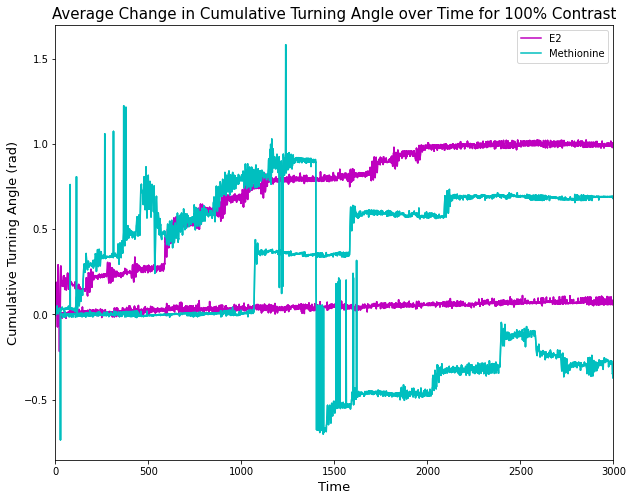

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.title("Average Change in Cumulative Turning Angle over Time for 100% Contrast",fontsize=15)
ax.set_xlabel("Time",fontsize=13)
ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)
ax.set_xlim(0,3000)
ax.plot(avg_AM_LeC100_trajectory,c="m",label='E2')
ax.plot(avg_AM_LmeC100_trajectory,c="c",label='Methionine')
ax.plot(avg_PM_LeC100_trajectory,c="m")
ax.plot(avg_PM_LmeC100_trajectory,c="c")
ax.plot(avg_AM_ReC100_trajectory,c="m")
ax.plot(avg_AM_RmeC100_trajectory,c="c")
ax.plot(avg_PM_ReC100_trajectory,c="m")
ax.plot(avg_PM_RmeC100_trajectory,c="c")
plt.legend()
plt.show()

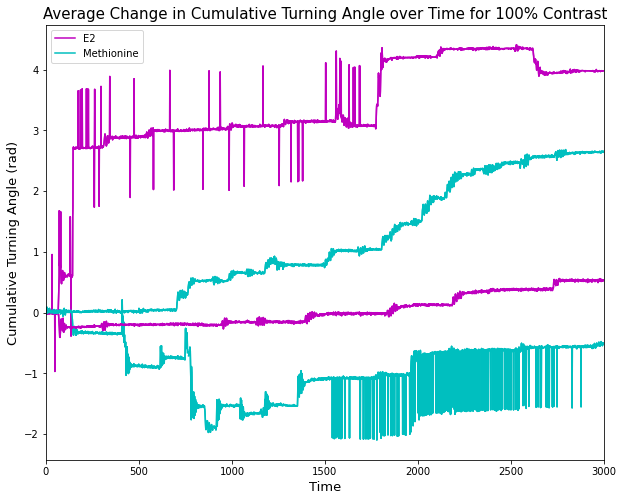

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
plt.title("Average Change in Cumulative Turning Angle over Time for 100% Contrast",fontsize=15)
ax.set_xlabel("Time",fontsize=13)
ax.set_ylabel("Cumulative Turning Angle (rad)",fontsize=13)
ax.set_xlim(0,3000)
ax.plot(avg_AM_LeC70_trajectory,c="m",label='E2')
ax.plot(avg_AM_LmeC70_trajectory,c="c",label='Methionine')
ax.plot(avg_PM_LeC70_trajectory,c="m")
ax.plot(avg_PM_LmeC70_trajectory,c="c")
ax.plot(avg_AM_ReC70_trajectory,c="m")
ax.plot(avg_AM_RmeC70_trajectory,c="c")
ax.plot(avg_PM_ReC70_trajectory,c="m")
ax.plot(avg_PM_RmeC70_trajectory,c="c")
plt.legend()
plt.show()